**Step 1: GPU Configuration and Mounting Google Drive**

In [1]:
# GPU configuration
!nvidia-smi

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


/bin/bash: line 1: nvidia-smi: command not found
Mounted at /content/drive


**Step 2: Install Required Packages**

In [2]:
# Install required packages
!pip install tensorflow_addons
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 6.8 MB/s eta 0:00:00


**Step 3: Import Libraries**

In [3]:
# Import libraries
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import warnings
import itertools
import pandas as pd
from PIL import Image
from sklearn.utils import class_weight
from collections import Counter
import tensorflow_addons as tfa
import visualkeras
import plotly.express as px
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
%matplotlib inline


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


**Step 4: Define Labels and Image Size**

In [4]:
# Define labels and image size
labels = ["Cucumber Mosaic Virus", "Downy Mildew", "Leaf Spot"]
img_size = 32


**Step 5: Get Data Function**

In [5]:
# Function to get data
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

**Step 6: Load Data**

In [6]:
# Load data
data_dir = get_data("/content/drive/MyDrive/Luffa Aegyptiaca 480")


**Step 7: Display Total Number of Training Images**

In [7]:
# Display total number of training images
image_names = glob.glob(os.path.join('/content/drive/MyDrive/Luffa Aegyptiaca 480', '*', '*'))
print("Total number of training images: ", len(image_names))

Total number of training images:  6533


**Step 8: Create DataFrame with Filename and ClassId**

In [8]:
# Create a DataFrame with Filename and ClassId
data_df = pd.DataFrame()
data_df['Filename'] = [img_name.split("/")[-1] for img_name in image_names]
data_df['ClassId'] = [img_name.split("/")[-2] for img_name in image_names]



**Step 9: Display Sample Images**

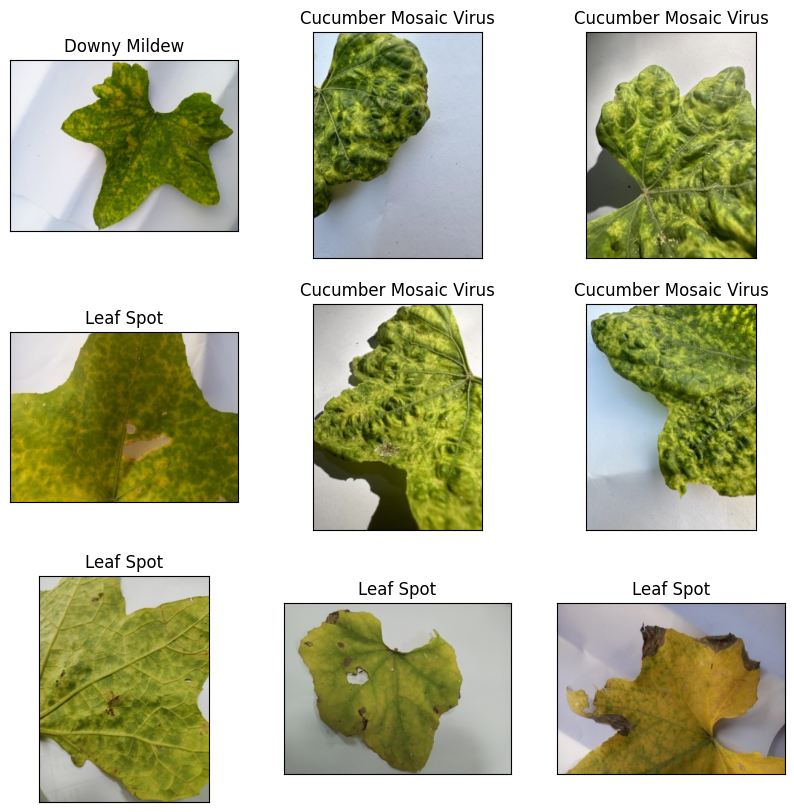

In [9]:
# Display sample images
plot_df = data_df.sample(min(9, len(data_df))).reset_index()
plt.figure(figsize=(10, 10))
for i in range(9):
    img_name = plot_df.loc[i, 'Filename']
    label_str = (plot_df.loc[i, 'ClassId'])
    plt.subplot(3, 3, i+1)
    plt.imshow(plt.imread(os.path.join('/content/drive/MyDrive/Luffa Aegyptiaca 480', label_str, img_name)))
    plt.title(label_str)
    plt.xticks([])
    plt.yticks([])


**Step 10: Display Class Distribution**

<BarContainer object of 3 artists>

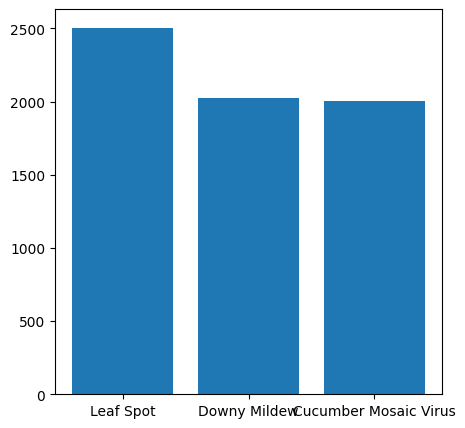

In [10]:
# Display class distribution
class_id_distribution = data_df['ClassId'].value_counts()
plt.figure(figsize=(5,5))
plt.xticks(np.arange(43))
plt.bar(class_id_distribution.index, class_id_distribution.values)


**Step 11: Preprocess and Split Data**

In [11]:
# Preprocess and split data
X = []
Y = []
for feature, label in data_dir:
  X.append(feature)
  Y.append(label)
X = np.array(X) / 255
X.reshape(-1, img_size, img_size, 1)
Y = np.array(Y)


**Step 12: Split Data with Stratified Sampling**

In [12]:
# Split data with stratified sampling
(x_train, x_test, y_train, y_test) = train_test_split(X, Y, test_size=0.10, stratify=Y, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.18, random_state=8)


**Step 13: Display Shapes of Train, Validation, and Test Sets**

In [13]:
# Display shapes of train, validation, and test sets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (4820, 32, 32, 3) - y_train shape: (4820,)
x_val shape: (1059, 32, 32, 3) - y_val shape: (1059,)
x_test shape: (654, 32, 32, 3) - y_test shape: (654,)


**Step 14: Install TensorFlow Addons**

In [14]:
# Install TensorFlow Addons
!pip install -U tensorflow-addons

**Step 15: Set Up Model Parameters**

In [15]:
# Set up model parameters
num_classes = 3
input_shape = (32, 32, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 250
image_size = 32
patch_size = 8
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 3
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 1
mlp_head_units = [2048, 1024]


**Step 16: Data Augmentation**

In [16]:
# Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)


**Step 17: Define MLP Function**

In [17]:
# Define MLP function
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


**Step 18: Define Patches Layer**

In [18]:
# Define Patches layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


**Step 19: Display Patches from a Sample Image**

(-0.5, 31.5, 31.5, -0.5)

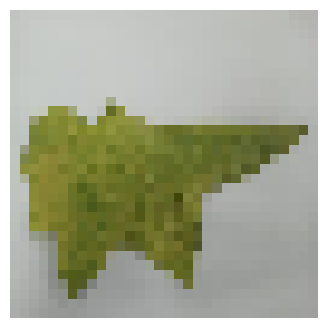

In [19]:
# Display patches from a sample image
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("float"))
plt.axis("off")


**Step 20: Define PatchEncoder Layer**

In [20]:
# Define PatchEncoder layer
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


**Step 21: Define ViT Model**

In [21]:
# Define ViT model
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(num_classes)(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


**Step 22: Run Experiment**

In [22]:
# Run experiment
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    model.summary()

    checkpoint_filepath = "/content/drive/MyDrive/model/model64_12.h5"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
        lr_reducer=tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.1,
            cooldown=10,
            patience=10,
            verbose=1,
            min_lr=0.1e-7
        ),
        early_stopping=tf.keras.callbacks.EarlyStopping(
            patience=15,
            verbose=1,
            mode='auto'
        )
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_val, y_val),
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


**Step 23: Create and Run ViT Model**

In [23]:
# Create and run ViT model
vit_classifier = create_vit_classifier()
vit_history = run_experiment(vit_classifier)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 32, 32, 3)            7         ['input_1[0][0]']             
 ial)                                                                                             
                                                                                                  
 patches (Patches)           (None, None, 192)            0         ['data_augmentation[0][0]']   
                                                                                                  
 patch_encoder (PatchEncode  (None, 16, 64)               13376     ['patches[0][0]']         

**Step 24: Plot Training and Validation Metrics**

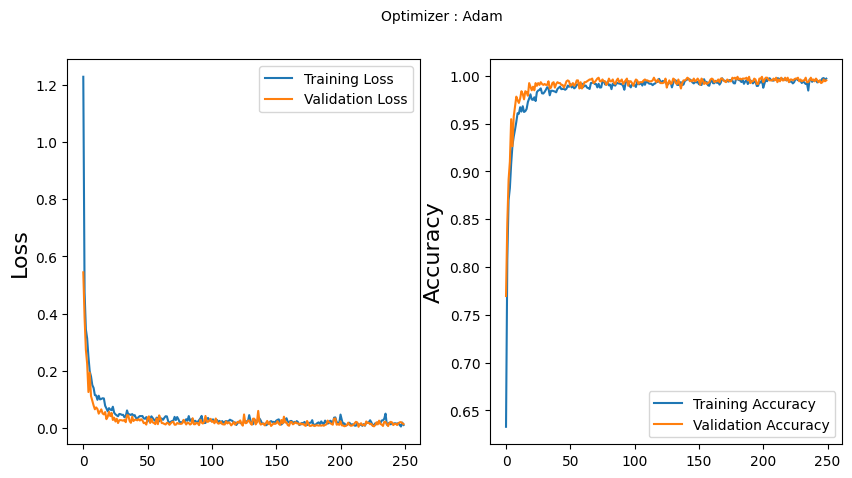

In [24]:
# Plot training and validation metrics
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(vit_history.history['loss'], label='Training Loss')
plt.plot(vit_history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(vit_history.history['accuracy'], label='Training Accuracy')
plt.plot(vit_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


**Step 25: Evaluate ViT Model on Validation Set**

In [25]:
# Evaluate ViT model on validation set
vit_predictions = vit_classifier.predict(x_val)
vit_y_pred = [np.argmax(probas) for probas in vit_predictions]


34/34 [==============================] - 1s 19ms/step


**Step 26: Plot Normalized Confusion Matrix for Validation Set**

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



**Step 27: Display Classification Report for Validation Set**

In [29]:
# Display classification report for validation set
print(classification_report(y_val, vit_y_pred, target_names=labels))

                       precision    recall  f1-score   support

Cucumber Mosaic Virus       1.00      1.00      1.00       305
         Downy Mildew       1.00      1.00      1.00       333
            Leaf Spot       1.00      1.00      1.00       421

             accuracy                           1.00      1059
            macro avg       1.00      1.00      1.00      1059
         weighted avg       1.00      1.00      1.00      1059



**Step 28: Evaluate ViT Model on Test Set**

In [30]:
# Evaluate ViT model on test set
vit_predictions_test = vit_classifier.predict(x_test)
vit_y_pred_test = [np.argmax(probas) for probas in vit_predictions_test]


21/21 [==============================] - 1s 38ms/step


**Step 29: Plot Normalized Confusion Matrix for Test Set**

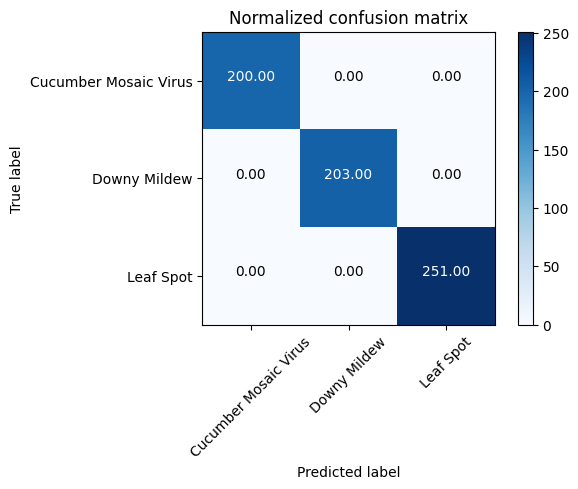

In [31]:
# Plot normalized confusion matrix for test set
cnf_matrix_test = confusion_matrix(y_test, vit_y_pred_test)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_test, classes=labels, title='Normalized confusion matrix')
plt.show()


**Step 30: Display Classification Report for Test Set**

In [32]:
# Display classification report for test set
print(classification_report(y_test, vit_y_pred_test, target_names=labels))


                       precision    recall  f1-score   support

Cucumber Mosaic Virus       1.00      1.00      1.00       200
         Downy Mildew       1.00      1.00      1.00       203
            Leaf Spot       1.00      1.00      1.00       251

             accuracy                           1.00       654
            macro avg       1.00      1.00      1.00       654
         weighted avg       1.00      1.00      1.00       654

